In [1]:
import qiime2 as q2
import pandas as pd
import numpy as np
from biom import Table, load_table
from biom.util import biom_open
from skbio import DistanceMatrix, OrdinationResults
from skbio.stats.distance import permanova, anosim
from qiime2.plugins.gemelli.actions import ctf, rpca
from qiime2.plugins.longitudinal.actions import volatility
from qiime2.plugins.emperor.actions import biplot
from assets.step_wise_anova import run_stepwise_anova

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline

def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10', style_order=None, dashes_=True):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """
    

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=dashes_,
                 ci=ci,
                 sort=True,
                 markers=style_order,
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    
    
    ax.set_title(title, fontsize=title_fontsize, y=1.25)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax

# microbiome

In [2]:
# microbiome
micro_mf = pd.read_csv('../data/diet_metadata_april20_microbiome.txt',
                       sep='\t', index_col=0)
micro_bt = q2.Artifact.load('../data/feature-table-microbiome.qza').view(Table)

# subset b4 and after
micro_mf = micro_mf[micro_mf['timepoint_verbose'] != 'day0']
use_sid = [k for k, v in micro_mf.host_subject_id.value_counts().items() if v == 2]
micro_mf = micro_mf[micro_mf.host_subject_id.isin(use_sid)]

freq_filter = 0.0
# subset data
micro_mf = micro_mf[~micro_mf.sample_type.isin(['control blank'])].copy()
micro_mf = micro_mf.replace(' ', '_', regex=True)
micro_mf.columns = [col_.replace(' ','') for col_ in micro_mf.columns]
micro_mf = micro_mf.drop(['dna_extracted','physical_specimen_remaining'], axis=1)
index_ = sorted(set(micro_bt.ids()) & set(micro_mf.index))
micro_mf = micro_mf.reindex(index_)
# filter table
micro_bt = micro_bt.filter(micro_mf.index)
keep_ = micro_bt.ids('observation')[micro_bt.sum('observation') > 0]
micro_bt = micro_bt.filter(keep_, 'observation')
freqs = micro_bt.matrix_data.toarray().astype(bool).sum(1) / micro_bt.shape[1]
keep_ = micro_bt.ids('observation')[freqs > freq_filter]
micro_bt = micro_bt.filter(keep_, 'observation')
# re-import 
q2micro_bt = q2.Artifact.import_data('FeatureTable[Frequency]', micro_bt)
q2micro_mf = q2.Metadata(micro_mf)
q2micro_bt


<artifact: FeatureTable[Frequency] uuid: 8bf70844-69b4-44c1-8384-250b77621049>

Mean of high quality read? Sd? What are the maximum reads per sample? Did authors filter low abundant/rare taxa? What is the total number of OTUs of the clean/filtered OTU table?



3,356 ASVs with a average total read count of 99,404 (s.t.d. 14,208) and a minimum of 62,568 counts and maximum of 134,654.



In [10]:
99404 - 14208

85196

In [21]:
subset_t = {t_:[tmf, micro_bt.copy().filter(tmf.index)]
            for t_, tmf in micro_mf.groupby('timepoint_verbose')}
subset_t_rpca = {t_:rpca(q2.Artifact.import_data('FeatureTable[Frequency]', bt_),
                         n_components=2,
                         min_feature_frequency=5)
                 for t_, (mf_, bt_) in subset_t.items()}


In [22]:
use = ['host_subject_id', 'age', 'BMI', 'CDAI_20_improvement',
       'CDAI_50_improvement', 'CDAI_70_improvement',
       'Response_ACR20', 'Response_ACR50', 'remission',
       'Pain_50_improvement', 'HAQ_50_improvement',
       'HAQ_20_improvement','VAS_Patient_20_improvement',
       'VAS_Patient_50_improvement', 'VAS_MD_20_improvement',
       'VAS_MD_50_improvement','Fatigue_20_improvement',
       'Fatigue_50_improvement','NSAIDs', 'host_height'] 

"""use = ['host_subject_id', 'age', 'BMI', 
       'Pain_50_improvement'] """

def run_ef(mf, ordres, use):
    ord_tmp = ordres.biplot.view(OrdinationResults).samples
    ord_tmp.columns = ['PC1','PC2','PC3']
    ord_tmp = pd.concat([ord_tmp, mf], axis=1).dropna(subset=['PC1'])
    es = run_stepwise_anova(ord_tmp[['PC1','PC2','PC3']], ord_tmp, use)
    es = es.rename({'R2.adj':'Effect-Size'},axis=1)
    return es, ord_tmp

es_t = {t_:run_ef(subset_t[t_][0], rpca_tmp, use) for t_, rpca_tmp in subset_t_rpca.items()}
es_t_df = pd.concat({k:v[0] for k, v in es_t.items()})
es_t_df


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp1t61ix71/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp1t61ix71/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp1t61ix71/output.effect.size.tsv

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpgqwfjm6a/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpgqwfjm6a/mf_.txt /var/folder

Effect-Size  Df        AIC          F  \
day+14 + VAS_MD_20_improvement          0.151168   1 -23.711595   3.493248   
       + VAS_Patient_50_improvement     0.150564   1 -25.841108   3.803122   
       + Pain_50_improvement            0.029085   1 -25.784449   1.521552   
       + NSAIDs                         0.030102   1 -25.904490   1.518116   
       + Response_ACR20                 0.025273   1 -26.090138   1.411745   
       + HAQ_50_improvement             0.009422   1 -26.088928   1.140309   
       + CDAI_50_improvement            0.003580   1 -26.181007   1.047666   
       + CDAI_70_improvement            0.250213   1 -34.572938   5.995779   
       + CDAI_20_improvement            0.002292   1 -35.406148   1.039484   
       + host_subject_id                0.053593   1 -39.259532   1.909256   
       + VAS_MD_50_improvement          0.088607   1 -46.939039   2.719679   
       + age                            0.107018   1 -62.007147   4.240255   
       + BMI                            0.082110   1 -96.869448  10.675431   
day-14 + Pain_50_improvement            0.146369   1 -20.902415   3.229062   
       + HAQ_50_improvement             0.069980   1 -21.318069   2.071600   
       + CDAI_50_improvement            0.110855   1 -22.787719   2.812448   
       + CDAI_20_improvement            0.158974   1 -26.036686   4.093957   
       + BMI                            0.054946   1 -27.269000   2.077660   
       + Response_ACR20                 0.070136   1 -29.460600   2.443344   
       + VAS_MD_20_improvement          0.018253   1 -30.292017   1.344880   
       + host_subject_id                0.042755   1 -32.561243   1.782750   
       + VAS_Patient_50_improvement     0.037146   1 -35.369401   1.639155   
       + Fatigue_20_improvement         0.048549   1 -39.956277   1.802341   
       + age                            0.087568   1 -49.920130   2.700684   
       + CDAI_70_improvement            0.132007   1 -84.618727  12.753982   

                                       Pr(>F)  
day+14 + VAS_MD_20_improvement       0.025595  
       + VAS_Patient_50_improvement  0.019796  
       + Pain_50_improvement         0.231354  
       + NSAIDs                      0.240152  
       + Response_ACR20              0.263547  
       + HAQ_50_improvement          0.330334  
       + CDAI_50_improvement         0.378524  
       + CDAI_70_improvement         0.009398  
       + CDAI_20_improvement         0.369726  
       + host_subject_id             0.193361  
       + VAS_MD_50_improvement       0.150170  
       + age                         0.112577  
       + BMI                         0.128774  
day-14 + Pain_50_improvement         0.012797  
       + HAQ_50_improvement          0.113577  
       + CDAI_50_improvement         0.056389  
       + CDAI_20_improvement         0.020196  
       + BMI                         0.144171  
       + Response_ACR20              0.107578  
       + VAS_MD_20_improvement       0.299540  
       + host_subject_id             0.205759  
       + VAS_Patient_50_improvement  0.239952  
       + Fatigue_20_improvement      0.235153  
       + age                         0.189962  
       + CDAI_70_improvement         0.112977

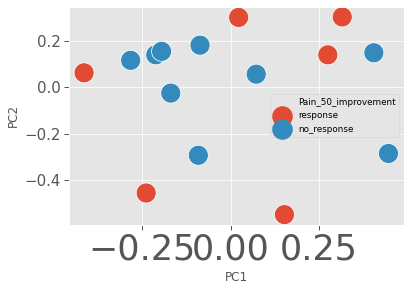

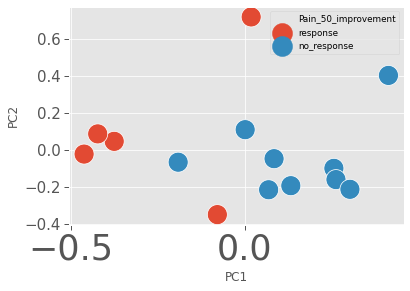

In [23]:

sns.scatterplot(x='PC1', y='PC2', hue='Pain_50_improvement', data=es_t['day+14'][1])
plt.show()

sns.scatterplot(x='PC1', y='PC2', hue='Pain_50_improvement', data=es_t['day-14'][1])
plt.show()


In [24]:
micro_mf['remission']

#SampleID
12766.DIET.001.1S      yes
12766.DIET.003.1S      yes
12766.DIET.004.1S       no
12766.DIET.006.1S       no
12766.DIET.007.1S       no
12766.DIET.009.1S       no
12766.DIET.019.1S      yes
12766.DIET.025.1S       no
12766.DIET.027.1S       no
12766.DIET.031.001S     no
12766.DIET.033.1S       no
12766.DIET.037.2S      yes
12766.DIET.039.1S       no
12766.DIET.046.1S      yes
12766.DIET.048.1S      yes
12766.DIET.057.1S       no
12766.DIET.064.1S       no
12766.DIET.066.1S       no
12766.DIET.067.1S      yes
12766.DIET.069.1S      yes
12766.DIET.070.1S       no
12766.DIET.072.1S       no
12766.DIET.075.1S      yes
12766.DIET.079.1S      yes
12766.DIET.081.5S      yes
12766.DIET.085.1S       no
12766.DIET.087.1S       no
12766.DIET.091.6S      yes
12766.DIET.093.1S      yes
Name: remission, dtype: object

In [25]:
# write for songbird
with biom_open('../data/microbiome-cleaned.biom', 'w') as f:
    micro_bt.to_hdf5(f, "example")
micro_mf.to_csv('../data/microbiome-cleaned.tsv', sep='\t')   

In [26]:
# build the set of all rep-seqs
seqs_ =load_table('../data/microbiome-cleaned.biom').ids('observation')
seqs_ = '\n'.join(['>'+i+'\n'+i for i in seqs_])
f = open("../data/rep-seqs.fa", "w")
f.write(seqs_)
f.close()


In [27]:
# run ctf 
micro_res = ctf(q2micro_bt,
                q2micro_mf,
                'host_subject_id',
                'timepoint_numeric',
                 max_iterations_als=55,
                 max_iterations_rptm=55)

for name_, art_ in micro_res.__dict__.items():
    if name_ != '_fields':
        art_.save('../results/ctf/microbiome-%s' % name_)

micro_res

Results (name = value)
--------------------------------------------------------------------------------------------------------------------
subject_biplot           = <artifact: PCoAResults % Properties('biplot') uuid: 4f0b1ce9-6713-4885-9e82-583f448da614>
state_biplot             = <artifact: PCoAResults % Properties('biplot') uuid: 432df5e1-9ea5-453e-8723-4b516d2209ef>
distance_matrix          = <artifact: DistanceMatrix uuid: 2b2d66f5-a082-4d12-9408-bb2434361793>
state_subject_ordination = <artifact: SampleData[SampleTrajectory] uuid: 535686b7-fbd6-44cc-a8c9-233d1813e7aa>
state_feature_ordination = <artifact: FeatureData[FeatureTrajectory] uuid: b8f632e4-4bed-42ef-b6fe-9af9affddb05>

In [28]:
mf_subject = q2micro_mf.to_dataframe().copy()


use_agg = ['age', 'BMI', 'CDAI_20_improvement',
           'CDAI_50_improvement', 'CDAI_70_improvement',
           'Response_ACR20', 'Response_ACR50', 'remission',
           'Pain_50_improvement', 'HAQ_50_improvement','HAQ_20_improvement',
           'VAS_Patient_20_improvement',
           'VAS_Patient_50_improvement', 'VAS_MD_20_improvement',
           'VAS_MD_50_improvement',
           'Fatigue_20_improvement','Fatigue_50_improvement',
           'NSAIDs', 'host_height'] 
mf_subject = mf_subject.groupby('host_subject_id').agg({v:'last' for v in use_agg})

ord_subject = micro_res.subject_biplot.view(OrdinationResults).samples
ord_subject.columns = ['PC1','PC2','PC3']
ord_subject = pd.concat([ord_subject, mf_subject], axis=1)
es = run_stepwise_anova(ord_subject[['PC1','PC2','PC3']], ord_subject, use_agg)
es = es.rename({'R2.adj':'Effect-Size'},axis=1)
es.to_csv('../results/tables-figures/tables/effect-size-microbiome.tsv', sep='\t')
es


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpvc35pq38/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpvc35pq38/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpvc35pq38/output.effect.size.tsv



,Effect-Size,Df,AIC,F,Pr(>F)
+ VAS_Patient_20_improvement,0.082539,1,-22.545370,2.259508,0.077784
+ Response_ACR20,0.060898,1,-22.776242,1.924243,0.135773
+ HAQ_50_improvement,0.049284,1,-22.970282,1.732587,0.174165
+ NSAIDs,0.053922,1,-23.436889,1.787334,0.171366


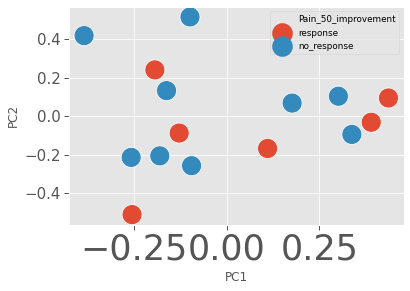

In [29]:

sns.scatterplot(x='PC1', y='PC2', hue='Pain_50_improvement', data=ord_subject)
plt.show()



In [30]:
# run ctf 
rpca_res = rpca(q2micro_bt)


In [31]:
mf_subject = q2micro_mf.to_dataframe().copy()

use_agg = ['host_subject_id','timepoint_numeric','age', 'BMI', 'CDAI_20_improvement',
           'CDAI_50_improvement', 'CDAI_70_improvement',
           'Response_ACR20', 'Response_ACR50', 'remission',
           'Pain_50_improvement', 'HAQ_50_improvement','HAQ_20_improvement',
           'VAS_Patient_20_improvement',
           'VAS_Patient_50_improvement', 'VAS_MD_20_improvement',
           'VAS_MD_50_improvement',
           'Fatigue_20_improvement','Fatigue_50_improvement',
           'NSAIDs', 'host_height'] 

ord_subject = rpca_res.biplot.view(OrdinationResults).samples
ord_subject.columns = ['PC1','PC2','PC3']
ord_subject = pd.concat([ord_subject, mf_subject], axis=1)
es = run_stepwise_anova(ord_subject[['PC1','PC2','PC3']], ord_subject, use_agg)
es = es.rename({'R2.adj':'Effect-Size'},axis=1)
es.to_csv('../results/tables-figures/tables/effect-size-microbiome.tsv', sep='\t')
es

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp2wzlc6vu/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp2wzlc6vu/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp2wzlc6vu/output.effect.size.tsv



,Effect-Size,Df,AIC,F,Pr(>F)
+ Pain_50_improvement,0.137463,1,-67.134938,5.462391,0.001200
+ VAS_MD_20_improvement,0.065139,1,-68.506603,3.205611,0.022595
+ VAS_Patient_50_improvement,0.100839,1,-71.564843,4.763949,0.004399
+ HAQ_50_improvement,0.057475,1,-73.246042,3.248316,0.034193
+ NSAIDs,0.062994,1,-75.489649,3.624330,0.019596
+ Response_ACR20,0.068351,1,-78.441318,4.096199,0.008198
+ timepoint_numeric,0.065757,1,-81.812675,4.273127,0.010598
+ CDAI_50_improvement,0.042644,1,-84.169950,3.242514,0.023595
+ CDAI_70_improvement,0.077576,1,-89.921307,5.821920,0.002000
+ CDAI_20_improvement,0.047784,1,-94.151425,4.313758,0.009798


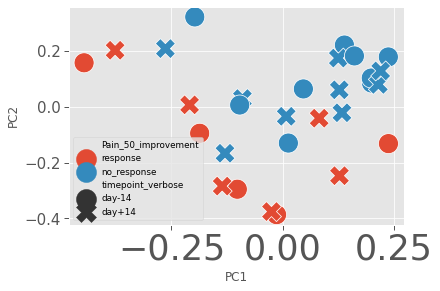

In [32]:
sns.scatterplot(x='PC1', y='PC2', style='timepoint_verbose', hue='Pain_50_improvement', data=ord_subject)
plt.show()


In [33]:
orddf = micro_res.state_subject_ordination.view(q2.Metadata).to_dataframe()
orddf[orddf=='nan'] = np.nan
usecols = ['subject_id','timepoint_numeric', 'age', 'BMI',
           'CDAI_20_improvement', 'CDAI_50_improvement', 'CDAI_70_improvement',
           'Response_ACR20', 'Response_ACR50', 'remission','Pain_50_improvement',
           'HAQ_50_improvement','HAQ_20_improvement', 'VAS_Patient_20_improvement',
           'VAS_Patient_50_improvement', 'VAS_MD_20_improvement', 'VAS_MD_50_improvement',
           'Fatigue_20_improvement','Fatigue_50_improvement',
           'NSAIDs', 'host_height'] 
es = run_stepwise_anova(orddf[['PC1','PC2','PC3']], orddf, usecols)
es = es.rename({'R2.adj':'Effect-Size'},axis=1)
es.to_csv('../results/tables-figures/tables/effect-size-microbiome.tsv', sep='\t')
es


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp3djgaicu/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp3djgaicu/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp3djgaicu/output.effect.size.tsv



,Effect-Size,Df,AIC,F,Pr(>F)
+ Pain_50_improvement,0.238108,1,215.431011,9.750638,0.001600
+ VAS_MD_20_improvement,0.199692,1,207.522086,10.590316,0.001200
+ VAS_Patient_50_improvement,0.125231,1,201.076792,8.451374,0.001200
+ Response_ACR20,0.064874,1,197.232308,5.358666,0.005799
+ VAS_MD_50_improvement,0.021736,1,196.252575,2.488914,0.099380
+ subject_id,0.028465,1,194.506134,3.033879,0.066387
+ HAQ_20_improvement,0.047455,1,190.531796,4.804118,0.011798
+ VAS_Patient_20_improvement,0.018131,1,189.134770,2.485511,0.103179
+ age,0.005038,1,189.071525,1.401029,0.245151


In [34]:
dist = micro_res.distance_matrix.view(DistanceMatrix)
permanova(dist, micro_mf['host_subject_id'])


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                 15
test statistic              3.78268
p-value                       0.002
number of permutations          999
Name: PERMANOVA results, dtype: object

In [35]:
dist = micro_res.distance_matrix.view(DistanceMatrix)
perm_t = {}
for t_, tmf in micro_mf.groupby('timepoint_verbose'):
    perm_t[t_] = pd.DataFrame(permanova(dist.filter(tmf.index),
                                        tmf['Pain_50_improvement'],
                                        permutations=1000))
pd.concat(perm_t)


PERMANOVA results
day+14 method name                    PERMANOVA
       test statistic name             pseudo-F
       sample size                           15
       number of groups                       2
       test statistic                   4.09072
       p-value                         0.048951
       number of permutations              1000
day-14 method name                    PERMANOVA
       test statistic name             pseudo-F
       sample size                           14
       number of groups                       2
       test statistic                   5.14807
       p-value                         0.017982
       number of permutations              1000

In [36]:
visual = volatility(micro_res.state_subject_ordination.view(q2.Metadata),
                    'timepoint_numeric',
                    individual_id_column='subject_id',
                    default_group_column='Pain_50_improvement',
                    default_metric='PC1')
#visual.visualization.save('../results/ctf/microbiome-volitility.qza')
#visual.visualization

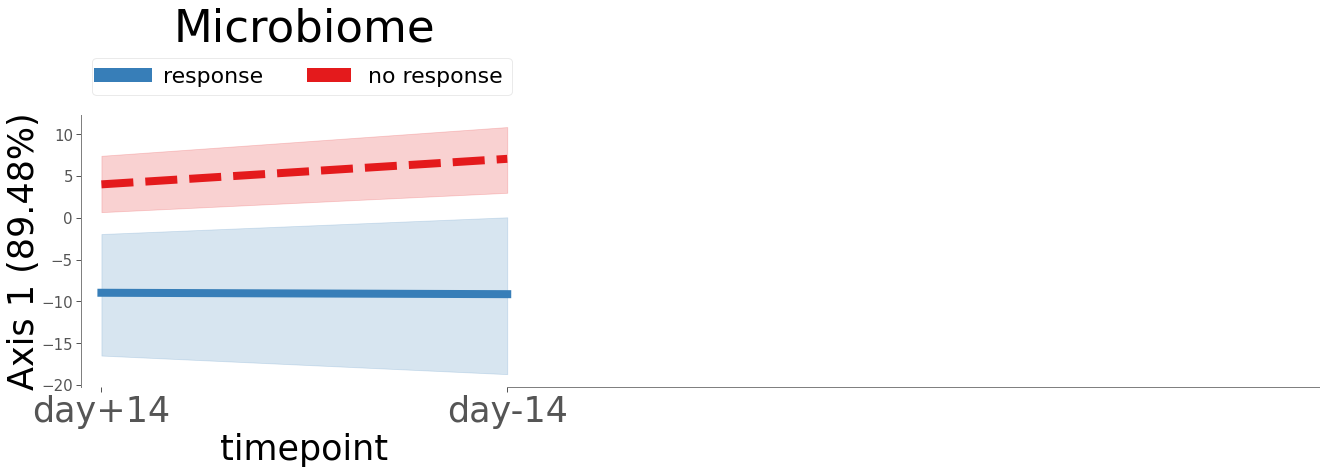

In [37]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 35 
plt.rcParams['ytick.labelsize'] = 15


plotdf = micro_res.state_subject_ordination.view(q2.Metadata).to_dataframe()
ord_ = micro_res.subject_biplot.view(OrdinationResults)
propexp = ord_.proportion_explained

fig, ax = plt.subplots(1,1, figsize=(8,5))

cmap_ = {'no_response':'#e41a1c','response':'#377eb8'}
time_ = 'timepoint_verbose'
y_ = 'PC1'
hue_ = 'Pain_50_improvement'
PC_label = 'Axis 1' + ' (%.2f%%)'%(propexp[0]*100)
ax = temporal_plot(time_, y_, plotdf, ax,
                   'Microbiome', 'timepoint', PC_label, 45, 35, 35,
                   hue=hue_, style=hue_, min_x=1.0, max_x = 3.0,
                   ci=68, cmap=cmap_)
#ax.set_ylim(-70, 50)
# generate legend from last iterations
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], [x.replace('_',' ') for x in labels[1:]], loc=2,
                         bbox_to_anchor=(0.0, 1.25),
                         prop={'size':22},
                         fancybox=True, framealpha=0.5, 
                         ncol=3, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(22.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(14.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

plt.savefig('../results/tables-figures/figures/CTF-PC1-microbiome.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

# metabolomics

In [6]:
# metabolomics
metab_mf = pd.read_csv('../data/diet_metadata_metabolomics_paired.txt',
                       sep='\t', index_col=0)
metab_bt = q2.Artifact.load('../data/Updated_data/qiime2_table.qza').view(Table)

metab_mf = metab_mf[metab_mf.ATTRIBUTE_SampleTypeSub1 == 'stool']

#metabdata = metab_bt.matrix_data.toarray()
#metabdata[metabdata <= 6e7] = 0.0
#metab_bt = Table(metabdata, metab_bt.ids('observation'), metab_bt.ids())

# subset data
rename_ = {'day+14':'3', 'day-14':'1', 'day0':'2'}
metab_mf = metab_mf.replace(' ', '_', regex=True)
metab_mf.columns = [col_.replace(' ','') for col_ in metab_mf.columns]
metab_mf = metab_mf.drop([], axis=1)
index_ = sorted(set(metab_bt.ids()) & set(metab_mf.index))
metab_mf = metab_mf.reindex(index_)
metab_mf['timepoint_numeric'] = [rename_[v] for v in metab_mf.ATTRIBUTE_Time]
metab_mf = metab_mf[metab_mf.ATTRIBUTE_Time.isin(['day+14', 'day-14'])]
use_sid = [k for k, v in metab_mf.ATTRIBUTE_id.value_counts().items() if v == 2]
metab_mf = metab_mf[metab_mf.ATTRIBUTE_id.isin(use_sid)]

# filter table
metab_bt = metab_bt.filter(metab_mf.index)
keep_ = metab_bt.ids('observation')[metab_bt.sum('observation') > 0]
metab_bt = metab_bt.filter(keep_, 'observation')
# re-import 
q2metab_bt = q2.Artifact.import_data('FeatureTable[Frequency]', metab_bt)
q2metab_mf = q2.Metadata(metab_mf)
metab_bt


6550 x 34 <class 'biom.table.Table'> with 108398 nonzero entries (48% dense)

In [7]:
metab_mf.ATTRIBUTE_SampleTypeSub1.value_counts()


stool    34
Name: ATTRIBUTE_SampleTypeSub1, dtype: int64

In [8]:
subset_t = {t_:[tmf, metab_bt.copy().filter(tmf.index)]
            for t_, tmf in metab_mf.groupby('ATTRIBUTE_Time')}
subset_t_rpca = {t_:rpca(q2.Artifact.import_data('FeatureTable[Frequency]', bt_),
                         n_components=2,
                         min_feature_frequency=5)
                 for t_, (mf_, bt_) in subset_t.items()}


In [9]:
use = ['ATTRIBUTE_id',
           'ATTRIBUTE_AgeInYears',
           'ATTRIBUTE_CDAI_20', 'ATTRIBUTE_CDAI_50',
           'ATTRIBUTE_CDAI_70', 'ATTRIBUTE_ACR20', 'ATTRIBUTE_ACR50',
           'ATTRIBUTE_Baseline_diet', 'ATTRIBUTE_Pain_50',
           'ATTRIBUTE_HAQ_50', 'ATTRIBUTE_VAS_Patient_50',
           'ATTRIBUTE_VAS_MD_50', 'ATTRIBUTE_Fatigue_50',
           'ATTRIBUTE_NSAIDs'] 
def run_ef(mf, ordres, use):
    ord_tmp = ordres.biplot.view(OrdinationResults).samples
    ord_tmp.columns = ['PC1','PC2','PC3']
    ord_tmp = pd.concat([ord_tmp, mf], axis=1).dropna(subset=['PC1'])
    es = run_stepwise_anova(ord_tmp[['PC1','PC2','PC3']], ord_tmp, use)
    es = es.rename({'R2.adj':'Effect-Size'},axis=1)
    return es, ord_tmp

es_t = {t_:run_ef(subset_t[t_][0], rpca_tmp, use) for t_, rpca_tmp in subset_t_rpca.items()}
es_t_df = pd.concat({k:v[0] for k, v in es_t.items()})
es_t_df

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp2a4lr1af/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp2a4lr1af/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp2a4lr1af/output.effect.size.tsv

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpvc76krw0/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpvc76krw0/mf_.txt /var/folder

Effect-Size  Df        AIC         F  \
day+14 + ATTRIBUTE_ACR50              0.075317   1 -27.916554  2.303235   
       + ATTRIBUTE_VAS_Patient_50     0.173800   1 -30.628843  4.471903   
       + ATTRIBUTE_VAS_MD_50          0.023092   1 -30.419699  1.444212   
       + ATTRIBUTE_AgeInYears         0.081023   1 -31.786877  2.628563   
       + ATTRIBUTE_NSAIDs             0.024185   1 -31.913963  1.466162   
       + ATTRIBUTE_Pain_50            0.009332   1 -31.790986  1.167393   
       + ATTRIBUTE_Fatigue_50         0.081828   1 -34.016803  2.539801   
       + ATTRIBUTE_CDAI_50            0.067683   1 -36.335090  2.313549   
       + ATTRIBUTE_HAQ_50             0.023492   1 -37.488884  1.426887   
day-14 + ATTRIBUTE_NSAIDs             0.046730   1 -27.398943  1.784332   
       + ATTRIBUTE_CDAI_20            0.071705   1 -27.901215  2.220077   
       + ATTRIBUTE_AgeInYears         0.048926   1 -28.131725  1.822641   
       + ATTRIBUTE_Pain_50            0.044657   1 -28.429568  1.736739   
       + ATTRIBUTE_HAQ_50             0.052059   1 -29.070703  1.848874   
       + ATTRIBUTE_ACR20              0.045513   1 -29.776247  1.725134   
       + ATTRIBUTE_CDAI_50            0.081647   1 -31.706924  2.341186   
       + ATTRIBUTE_VAS_Patient_50     0.076702   1 -33.998624  2.297431   
       + ATTRIBUTE_CDAI_70            0.103146   1 -37.932150  2.923852   
       + ATTRIBUTE_ACR50              0.049537   1 -40.639033  1.914012   

                                     Pr(>F)  
day+14 + ATTRIBUTE_ACR50           0.071186  
       + ATTRIBUTE_VAS_Patient_50  0.002799  
       + ATTRIBUTE_VAS_MD_50       0.238952  
       + ATTRIBUTE_AgeInYears      0.066387  
       + ATTRIBUTE_NSAIDs          0.245351  
       + ATTRIBUTE_Pain_50         0.323535  
       + ATTRIBUTE_Fatigue_50      0.093781  
       + ATTRIBUTE_CDAI_50         0.115377  
       + ATTRIBUTE_HAQ_50          0.249950  
day-14 + ATTRIBUTE_NSAIDs          0.139972  
       + ATTRIBUTE_CDAI_20         0.092382  
       + ATTRIBUTE_AgeInYears      0.152370  
       + ATTRIBUTE_Pain_50         0.181164  
       + ATTRIBUTE_HAQ_50          0.151970  
       + ATTRIBUTE_ACR20           0.177165  
       + ATTRIBUTE_CDAI_50         0.084583  
       + ATTRIBUTE_VAS_Patient_50  0.092382  
       + ATTRIBUTE_CDAI_70         0.056389  
       + ATTRIBUTE_ACR50           0.153569

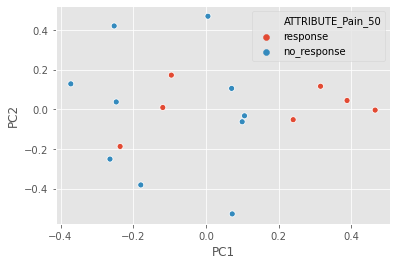

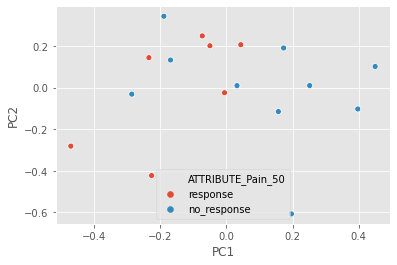

In [10]:
sns.scatterplot(x='PC1', y='PC2', hue='ATTRIBUTE_Pain_50', data=es_t['day-14'][1])
plt.show()

sns.scatterplot(x='PC1', y='PC2', hue='ATTRIBUTE_Pain_50', data=es_t['day+14'][1])
plt.show()


In [11]:
# write for songbird
with biom_open('../data/metabolite-cleaned.biom', 'w') as f:
    metab_bt.to_hdf5(f, "example")
metab_mf.to_csv('../data/metabolite-cleaned.tsv', sep='\t')   

In [12]:
# run ctf 
metab_res = ctf(q2metab_bt,
                q2metab_mf,
                'ATTRIBUTE_id',
                'timepoint_numeric',
                n_components = 3,
                max_iterations_als = 75,
                max_iterations_rptm = 75,
                n_initializations = 75)

for name_, art_ in metab_res.__dict__.items():
    if name_ != '_fields':
        art_.save('../results/ctf/metabolome-%s' % name_)

metab_res

Results (name = value)
--------------------------------------------------------------------------------------------------------------------
subject_biplot           = <artifact: PCoAResults % Properties('biplot') uuid: 3d941f2a-1cce-4189-abe6-c86242febcbf>
state_biplot             = <artifact: PCoAResults % Properties('biplot') uuid: 4390f00c-b56d-446d-8255-68db6d2b64ac>
distance_matrix          = <artifact: DistanceMatrix uuid: 0cbe6dcc-c17a-40dc-93cd-57f70697a0e0>
state_subject_ordination = <artifact: SampleData[SampleTrajectory] uuid: 2898d8e1-ed48-4ae8-825d-a4d94a277066>
state_feature_ordination = <artifact: FeatureData[FeatureTrajectory] uuid: c4275834-9b52-42f4-87b6-0a1cb3bdf4a8>

In [13]:
orddf = metab_res.state_subject_ordination.view(q2.Metadata).to_dataframe()
usecols = ['subject_id','timepoint_numeric',
           'ATTRIBUTE_AgeInYears',
           'ATTRIBUTE_CDAI_20', 'ATTRIBUTE_CDAI_50',
           'ATTRIBUTE_CDAI_70', 'ATTRIBUTE_ACR20', 'ATTRIBUTE_ACR50',
           'ATTRIBUTE_Baseline_diet', 'ATTRIBUTE_Pain_50',
           'ATTRIBUTE_HAQ_50', 'ATTRIBUTE_VAS_Patient_50',
           'ATTRIBUTE_VAS_MD_50', 'ATTRIBUTE_Fatigue_50',
           'ATTRIBUTE_NSAIDs'] 
es = run_stepwise_anova(orddf[['PC1','PC2','PC3']], orddf, usecols)
es = es.rename({'R2.adj':'Effect-Size'},axis=1)
es.to_csv('../results/tables-figures/tables/effect-size-metabolome.tsv', sep='\t')
es


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp7b9nubt3/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp7b9nubt3/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmp7b9nubt3/output.effect.size.tsv



,Effect-Size,Df,AIC,F,Pr(>F)
+ timepoint_numeric,0.081102,1,269.838191,3.912592,0.018796
+ ATTRIBUTE_Baseline_diet,0.025697,1,269.794387,1.920616,0.156169
+ ATTRIBUTE_CDAI_20,0.034916,1,269.323751,2.261131,0.114177
+ ATTRIBUTE_Pain_50,0.042596,1,268.440396,2.566626,0.087383
+ ATTRIBUTE_HAQ_50,0.057265,1,266.772391,3.189671,0.046991
+ ATTRIBUTE_CDAI_50,0.090643,1,263.208310,4.800637,0.013997
+ ATTRIBUTE_NSAIDs,0.053505,1,261.085571,3.351791,0.038592
+ ATTRIBUTE_VAS_Patient_50,0.074368,1,257.364502,4.581304,0.013597
+ ATTRIBUTE_CDAI_70,0.138425,1,247.904576,9.619642,0.000200
+ ATTRIBUTE_ACR50,0.067734,1,242.175187,5.870756,0.003399


In [14]:
dist = metab_res.distance_matrix.view(DistanceMatrix)
perm_t = {}
for t_, tmf in metab_mf.groupby('timepoint_numeric'):
    perm_t[t_] = pd.DataFrame(permanova(dist.filter(tmf.index),
                                        tmf['ATTRIBUTE_Pain_50']))
pd.concat(perm_t)


PERMANOVA results
1 method name                    PERMANOVA
  test statistic name             pseudo-F
  sample size                           17
  number of groups                       2
  test statistic                   1.68371
  p-value                            0.212
  number of permutations               999
3 method name                    PERMANOVA
  test statistic name             pseudo-F
  sample size                           17
  number of groups                       2
  test statistic                  0.371974
  p-value                            0.558
  number of permutations               999

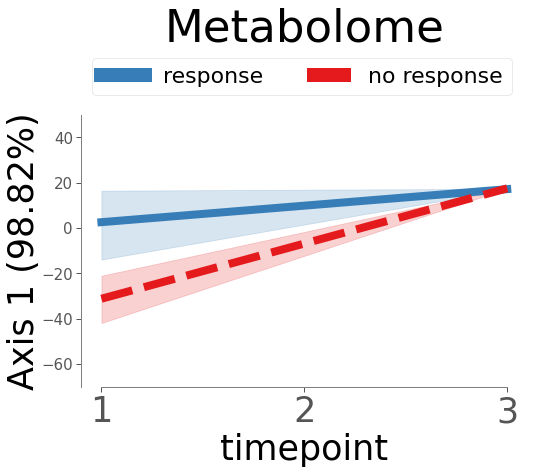

In [16]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 20}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 35 
plt.rcParams['ytick.labelsize'] = 15


plotdf = metab_res.state_subject_ordination.view(q2.Metadata).to_dataframe()
ord_ = metab_res.subject_biplot.view(OrdinationResults)
propexp = ord_.proportion_explained

fig, ax = plt.subplots(1,1, figsize=(8,5))

cmap_ = {'no_response':'#e41a1c','response':'#377eb8'}
time_ = 'timepoint_numeric'
y_ = 'PC1'
hue_ = 'ATTRIBUTE_Pain_50'
PC_label = 'Axis 1' + ' (%.2f%%)'%(propexp[0]*100)
ax = temporal_plot(time_, y_, plotdf, ax,
                   'Metabolome', 'timepoint', PC_label, 45, 35, 35,
                   hue=hue_, style=hue_, min_x=1.0, max_x = 3.0,
                   ci=68, cmap=cmap_)
ax.set_ylim(-70, 50)
# generate legend from last iterations
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], [x.replace('_',' ') for x in labels[1:]], loc=2,
                         bbox_to_anchor=(0.0, 1.25),
                         prop={'size':22},
                         fancybox=True, framealpha=0.5, 
                         ncol=3, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(22.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(14.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)


plt.savefig('../results/tables-figures/figures/CTF-PC1-metabolome.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()

## combine both groups

In [31]:
"""both_groups = pd.DataFrame({k:[len(set(df.host_subject_id)) ]
                            for k, df in micro_mf.groupby(['Pain_50_improvement'])}).T
both_groups.index.names = ['Pain_50 and','CDAI_70']
both_groups.columns = ['N-subjects']
both_groups

micro_mf['Pain_50_CDAI_70'] = micro_mf['Pain_50'] + '-&-'+ micro_mf['CDAI_70']
metab_mf['Pain_50_CDAI_70'] = metab_mf['ATTRIBUTE_Pain_50'] + '-&-'+ metab_mf['ATTRIBUTE_CDAI_70']"""

"both_groups = pd.DataFrame({k:[len(set(df.host_subject_id)) ]\n                            for k, df in micro_mf.groupby(['Pain_50_improvement'])}).T\nboth_groups.index.names = ['Pain_50 and','CDAI_70']\nboth_groups.columns = ['N-subjects']\nboth_groups\n\nmicro_mf['Pain_50_CDAI_70'] = micro_mf['Pain_50'] + '-&-'+ micro_mf['CDAI_70']\nmetab_mf['Pain_50_CDAI_70'] = metab_mf['ATTRIBUTE_Pain_50'] + '-&-'+ metab_mf['ATTRIBUTE_CDAI_70']"

In [32]:
dist = micro_res.distance_matrix.view(DistanceMatrix)
perm_t = {}
for t_, tmf in micro_mf.groupby('timepoint_numeric'):
    perm_t[t_] = pd.DataFrame(anosim(dist.filter(tmf.index),
                                        tmf['Pain_50_improvement']))
pd.concat(perm_t)


ANOSIM results
1.0 method name                    ANOSIM
    test statistic name                 R
    sample size                        14
    number of groups                    2
    test statistic               0.283092
    p-value                         0.029
    number of permutations            999
3.0 method name                    ANOSIM
    test statistic name                 R
    sample size                        15
    number of groups                    2
    test statistic               0.143791
    p-value                         0.095
    number of permutations            999

In [33]:
"""dist = metab_res.distance_matrix.view(DistanceMatrix)
perm_t = {}
for t_, tmf in metab_mf.groupby('timepoint_numeric'):
    perm_t[t_] = pd.DataFrame(permanova(dist.filter(tmf.index),
                                        tmf['Pain_50']))
pd.concat(perm_t)"""

"dist = metab_res.distance_matrix.view(DistanceMatrix)\nperm_t = {}\nfor t_, tmf in metab_mf.groupby('timepoint_numeric'):\n    perm_t[t_] = pd.DataFrame(permanova(dist.filter(tmf.index),\n                                        tmf['Pain_50']))\npd.concat(perm_t)"

### match for mmvec


In [38]:
subset_ = sorted(set(micro_bt.ids()) & set(metab_bt.ids()))

mmvec_metab_bt = metab_bt.copy().filter(subset_)
keep_ = mmvec_metab_bt.ids('observation')[mmvec_metab_bt.sum('observation') > 0]
mmvec_metab_bt = mmvec_metab_bt.filter(keep_, 'observation')
with biom_open('../data/matched-mmvec/met.biom', 'w') as f:
    mmvec_metab_bt.to_hdf5(f, "example")
    
mmvec_micro_bt = micro_bt.copy().filter(subset_)
keep_ = mmvec_micro_bt.ids('observation')[mmvec_micro_bt.sum('observation') > 0]
mmvec_micro_bt = mmvec_micro_bt.filter(keep_, 'observation')
with biom_open('../data/matched-mmvec/micro.biom', 'w') as f:
    mmvec_micro_bt.to_hdf5(f, "example")


In [39]:
mmvec_micro_bt

3356 x 29 <class 'biom.table.Table'> with 10222 nonzero entries (10% dense)

In [40]:
mmvec_metab_bt

6508 x 29 <class 'biom.table.Table'> with 92705 nonzero entries (49% dense)

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


micro_mf_mmvec = micro_mf.copy().reindex(mmvec_micro_bt.ids())
metab_mf_mmvec = metab_mf.copy().reindex(micro_mf_mmvec.index)

micro_mf_mmvec['encode_Pain_50'] = le.fit_transform(micro_mf_mmvec['Pain_50_improvement'])
y = list(micro_mf_mmvec.loc[:,["encode_Pain_50"]].values.flatten())
split_ = train_test_split(np.array(micro_mf_mmvec.index).reshape(-1,1), y,
                          test_size=0.33,
                          random_state=42,
                          stratify=y)
train_index, test_index, y_train, y_test = split_
micro_mf_mmvec['stratified_test_labels'] = "Train"
micro_mf_mmvec.loc[list(test_index.flatten()), 'stratified_test_labels'] = "Test"
metab_mf_mmvec['stratified_test_labels'] = micro_mf_mmvec.stratified_test_labels

metab_mf_mmvec.to_csv('../data/matched-mmvec/met-mf.tsv', sep='\t')
micro_mf_mmvec.to_csv('../data/matched-mmvec/micro-mf.tsv', sep='\t')
len(test_index)

10

### run metabolomics with microbe metadata (bit hacky but needed for now)

In [62]:
q2mmvec_metab_bt = q2.Artifact.import_data('FeatureTable[Frequency]', mmvec_metab_bt)
q2micro_mf_mmvec = q2.Metadata(micro_mf_mmvec)
# run ctf 
mmvec_metab_res = ctf(q2mmvec_metab_bt,
                q2micro_mf_mmvec,
                'host_subject_id',
                'timepoint_numeric',
                n_components = 3,
                max_iterations_als = 75,
                max_iterations_rptm = 75,
                n_initializations = 75)

for name_, art_ in mmvec_metab_res.__dict__.items():
    if name_ != '_fields':
        art_.save('../results/ctf/match-mmvec-micro-metabolome-%s' % name_)

mmvec_metab_res

/Users/cmartino/Dropbox/bin/gemelli/gemelli/factorization.py:539: RuntimeWarning: A component of your data may be high-rank.
  RuntimeWarning)


Results (name = value)
--------------------------------------------------------------------------------------------------------------------
subject_biplot           = <artifact: PCoAResults % Properties('biplot') uuid: 73fa2d46-d902-4f93-8efb-c8065e4a22d1>
state_biplot             = <artifact: PCoAResults % Properties('biplot') uuid: b3821f57-91c2-4d6e-81da-aa00a8c5be8e>
distance_matrix          = <artifact: DistanceMatrix uuid: 200d5ce1-6f5c-4f1b-9ac7-18dc98c7ee7b>
state_subject_ordination = <artifact: SampleData[SampleTrajectory] uuid: 8aa2c785-7060-45c7-b6e3-b2a1f0dd22be>
state_feature_ordination = <artifact: FeatureData[FeatureTrajectory] uuid: 03e6367f-a623-420a-8c08-f416ced9fa44>

In [63]:
orddf = mmvec_metab_res.state_subject_ordination.view(q2.Metadata).to_dataframe()
orddf[orddf=='nan'] = np.nan
usecols = ['subject_id','timepoint_numeric', 'age', 'BMI',
           'CDAI_20_improvement', 'CDAI_50_improvement', 'CDAI_70_improvement',
           'Response_ACR20', 'Response_ACR50', 'remission','Pain_50_improvement',
           'HAQ_50_improvement','HAQ_20_improvement', 'VAS_Patient_20_improvement',
           'VAS_Patient_50_improvement', 'VAS_MD_20_improvement', 'VAS_MD_50_improvement',
           'Fatigue_20_improvement','Fatigue_50_improvement',
           'NSAIDs', 'HLD', 'HTN', 'DM', 'host_height'] 
es = run_stepwise_anova(orddf[['PC1','PC2','PC3']], orddf, usecols)
es = es.rename({'R2.adj':'Effect-Size'},axis=1)
#es.to_csv('../results/tables-figures/tables/effect-size-microbiome.tsv', sep='\t')
es

/Users/cmartino/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpg12w_ubl/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpg12w_ubl/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpg12w_ubl/output.effect.size.tsv



,Effect-Size,Df,AIC,F,Pr(>F)
+ Pain_50_improvement,0.212289,1,388.375737,13.666535,0.000400
+ host_height,0.132798,1,380.458547,10.327530,0.000200
+ VAS_MD_20_improvement,0.109910,1,372.561683,10.075126,0.000800
+ BMI,0.061355,1,367.725357,6.581788,0.001600
+ subject_id,0.055420,1,362.754243,6.564905,0.002200
+ VAS_Patient_50_improvement,0.041719,1,358.677583,5.533346,0.004399
+ VAS_MD_50_improvement,0.077886,1,348.690650,11.347036,0.000200
+ timepoint_numeric,0.040975,1,342.637908,7.123708,0.000800
+ NSAIDs,0.041171,1,335.373693,8.089753,0.000200
+ DM,0.017921,2,332.821546,2.632651,0.038992


# metabolome of plasma

In [31]:
# metabolomics
metab_mf = pd.read_csv('../data/diet_metadata_metabolomics_paired.txt',
                       sep='\t', index_col=0)
metab_bt = q2.Artifact.load('../data/Updated_data/qiime2_table.qza').view(Table)

metab_mf = metab_mf[metab_mf.ATTRIBUTE_SampleTypeSub1 == 'plasma']

# subset data
rename_ = {'day+14':'3', 'day-14':'1', 'day0':'2'}
metab_mf = metab_mf.replace(' ', '_', regex=True)
metab_mf.columns = [col_.replace(' ','') for col_ in metab_mf.columns]
metab_mf = metab_mf.drop([], axis=1)
index_ = sorted(set(metab_bt.ids()) & set(metab_mf.index))
metab_mf = metab_mf.reindex(index_)
metab_mf['timepoint_numeric'] = [rename_[v] for v in metab_mf.ATTRIBUTE_Time]
metab_mf = metab_mf[metab_mf.ATTRIBUTE_Time.isin(['day+14', 'day-14'])]
use_sid = [k for k, v in metab_mf.ATTRIBUTE_id.value_counts().items() if v == 2]
metab_mf = metab_mf[metab_mf.ATTRIBUTE_id.isin(use_sid)]

# filter table
metab_bt = metab_bt.filter(metab_mf.index)
keep_ = metab_bt.ids('observation')[metab_bt.sum('observation') > 0]
metab_bt = metab_bt.filter(keep_, 'observation')
# re-import 
q2metab_bt = q2.Artifact.import_data('FeatureTable[Frequency]', metab_bt)
q2metab_mf = q2.Metadata(metab_mf)
metab_bt


2136 x 40 <class 'biom.table.Table'> with 36890 nonzero entries (43% dense)

In [34]:
subset_t = {t_:[tmf, metab_bt.copy().filter(tmf.index)]
            for t_, tmf in metab_mf.groupby('ATTRIBUTE_Time')}
subset_t_rpca = {t_:rpca(q2.Artifact.import_data('FeatureTable[Frequency]', bt_),
                         n_components=2,
                         min_feature_frequency=5)
                 for t_, (mf_, bt_) in subset_t.items()}


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/gemelli/preprocessing.py:201: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [35]:
use = ['ATTRIBUTE_id',
           'ATTRIBUTE_AgeInYears',
           'ATTRIBUTE_CDAI_20', 'ATTRIBUTE_CDAI_50',
           'ATTRIBUTE_CDAI_70', 'ATTRIBUTE_ACR20', 'ATTRIBUTE_ACR50',
           'ATTRIBUTE_Baseline_diet', 'ATTRIBUTE_Pain_50',
           'ATTRIBUTE_HAQ_50', 'ATTRIBUTE_VAS_Patient_50',
           'ATTRIBUTE_VAS_MD_50', 'ATTRIBUTE_Fatigue_50',
           'ATTRIBUTE_NSAIDs'] 
def run_ef(mf, ordres, use):
    ord_tmp = ordres.biplot.view(OrdinationResults).samples
    ord_tmp.columns = ['PC1','PC2','PC3']
    ord_tmp = pd.concat([ord_tmp, mf], axis=1).dropna(subset=['PC1'])
    es = run_stepwise_anova(ord_tmp[['PC1','PC2','PC3']], ord_tmp, use)
    es = es.rename({'R2.adj':'Effect-Size'},axis=1)
    return es, ord_tmp

es_t = {t_:run_ef(subset_t[t_][0], rpca_tmp, use) for t_, rpca_tmp in subset_t_rpca.items()}
es_t_df = pd.concat({k:v[0] for k, v in es_t.items()})
es_t_df

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpuxxfq7hy/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpuxxfq7hy/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpuxxfq7hy/output.effect.size.tsv

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpbj72ggua/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpbj72ggua/mf_.txt /var/folder

Effect-Size  Df        AIC         F  \
day+14 + ATTRIBUTE_id                0.098973   1 -37.108137  3.087040   
       + ATTRIBUTE_Baseline_diet     0.040897   1 -37.180337  1.855852   
       + ATTRIBUTE_AgeInYears        0.038630   1 -37.311870  1.799412   
       + ATTRIBUTE_Fatigue_50        0.000005   1 -36.602769  1.000102   
day-14 + ATTRIBUTE_id                0.140424   1 -38.050054  4.103909   
       + ATTRIBUTE_AgeInYears        0.056493   1 -38.552854  2.266221   
       + ATTRIBUTE_Baseline_diet     0.024168   1 -38.376459  1.527464   

                                    Pr(>F)  
day+14 + ATTRIBUTE_id             0.026195  
       + ATTRIBUTE_Baseline_diet  0.147970  
       + ATTRIBUTE_AgeInYears     0.155969  
       + ATTRIBUTE_Fatigue_50     0.400320  
day-14 + ATTRIBUTE_id             0.003399  
       + ATTRIBUTE_AgeInYears     0.090582  
       + ATTRIBUTE_Baseline_diet  0.208358

In [36]:
# write for songbird
with biom_open('../data/plasma-metabolite-cleaned.biom', 'w') as f:
    metab_bt.to_hdf5(f, "example")
metab_mf.to_csv('../data/plasma-metabolite-cleaned.tsv', sep='\t')  

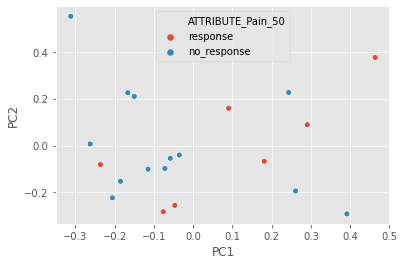

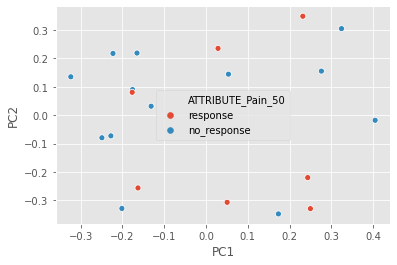

In [37]:
sns.scatterplot(x='PC1', y='PC2', hue='ATTRIBUTE_Pain_50', data=es_t['day-14'][1])
plt.show()

sns.scatterplot(x='PC1', y='PC2', hue='ATTRIBUTE_Pain_50', data=es_t['day+14'][1])
plt.show()

In [39]:
# run ctf 
metab_res = ctf(q2metab_bt,
                q2metab_mf,
                'ATTRIBUTE_id',
                'timepoint_numeric',
                n_components = 3,
                max_iterations_als = 75,
                max_iterations_rptm = 75,
                n_initializations = 75)

for name_, art_ in metab_res.__dict__.items():
    if name_ != '_fields':
        art_.save('../results/ctf/plasma-metabolome-%s' % name_)

metab_res

Results (name = value)
--------------------------------------------------------------------------------------------------------------------
subject_biplot           = <artifact: PCoAResults % Properties('biplot') uuid: db1a3d8a-c871-4d6d-997d-5dd002e899f3>
state_biplot             = <artifact: PCoAResults % Properties('biplot') uuid: 88289ae6-f40c-4313-81df-a04d84a1b7d1>
distance_matrix          = <artifact: DistanceMatrix uuid: fb4de651-c152-4732-88c9-334645624888>
state_subject_ordination = <artifact: SampleData[SampleTrajectory] uuid: 749651fe-3175-4ec3-bf88-fb12c059304a>
state_feature_ordination = <artifact: FeatureData[FeatureTrajectory] uuid: 0f83f1d4-f6bf-4e61-b434-c815e03adbd2>

In [40]:
orddf = metab_res.state_subject_ordination.view(q2.Metadata).to_dataframe()
usecols = ['subject_id','timepoint_numeric',
           'ATTRIBUTE_AgeInYears',
           'ATTRIBUTE_CDAI_20', 'ATTRIBUTE_CDAI_50',
           'ATTRIBUTE_CDAI_70', 'ATTRIBUTE_ACR20', 'ATTRIBUTE_ACR50',
           'ATTRIBUTE_Baseline_diet', 'ATTRIBUTE_Pain_50',
           'ATTRIBUTE_HAQ_50', 'ATTRIBUTE_VAS_Patient_50',
           'ATTRIBUTE_VAS_MD_50', 'ATTRIBUTE_Fatigue_50',
           'ATTRIBUTE_NSAIDs'] 
es = run_stepwise_anova(orddf[['PC1','PC2','PC3']], orddf, usecols)
es = es.rename({'R2.adj':'Effect-Size'},axis=1)
es.to_csv('../results/tables-figures/tables/plasma-effect-size-metabolome.tsv', sep='\t')
es


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /Users/cmartino/Dropbox/Krupp_diet_project/code/assets/stepwise-rda.R /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpavvamqzs/ord_.tsv /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpavvamqzs/mf_.txt /var/folders/tt/zz8n1d_55_n6r7czk3k1qwcw0000gp/T/tmpavvamqzs/output.effect.size.tsv



,Effect-Size,Df,AIC,F,Pr(>F)
+ subject_id,0.285981,1,235.177009,16.620401,0.000200
+ ATTRIBUTE_Fatigue_50,0.048225,1,233.313129,3.752408,0.033993
+ ATTRIBUTE_Baseline_diet,0.058642,1,230.529105,4.573678,0.018796
+ timepoint_numeric,0.025816,1,229.664276,2.598674,0.084583
+ ATTRIBUTE_AgeInYears,0.000307,1,230.483669,1.018473,0.355729
+ ATTRIBUTE_Pain_50,0.006033,1,230.872066,1.356719,0.251150
+ ATTRIBUTE_VAS_Patient_50,0.023207,1,229.993307,2.387905,0.106579
+ ATTRIBUTE_HAQ_50,0.015661,1,229.571637,1.934770,0.145771
+ ATTRIBUTE_VAS_MD_50,0.004309,1,229.937228,1.251195,0.265347
+ ATTRIBUTE_CDAI_50,0.015622,1,229.388576,1.907910,0.172166


In [41]:
dist = metab_res.distance_matrix.view(DistanceMatrix)
perm_t = {}
for t_, tmf in metab_mf.groupby('timepoint_numeric'):
    perm_t[t_] = pd.DataFrame(permanova(dist.filter(tmf.index),
                                        tmf['ATTRIBUTE_Pain_50']))
pd.concat(perm_t)


PERMANOVA results
1 method name                    PERMANOVA
  test statistic name             pseudo-F
  sample size                           20
  number of groups                       2
  test statistic                   1.44444
  p-value                            0.235
  number of permutations               999
3 method name                    PERMANOVA
  test statistic name             pseudo-F
  sample size                           20
  number of groups                       2
  test statistic                   1.14679
  p-value                            0.317
  number of permutations               999